In [1]:
# import pandas_datareader.data as webDataReader
# print (dir (webDataReader))
### pandas_datareader does not work anymore to access to yahoo finance data ###

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
start = '2010-01-01'
end = '2019-12-31'

df_downloaded = yf.download('AAPL', start = start, end = end, progress=False)
working_df = (df_downloaded.reset_index()).drop(['Date', 'Adj Close'], axis = 1)
working_df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


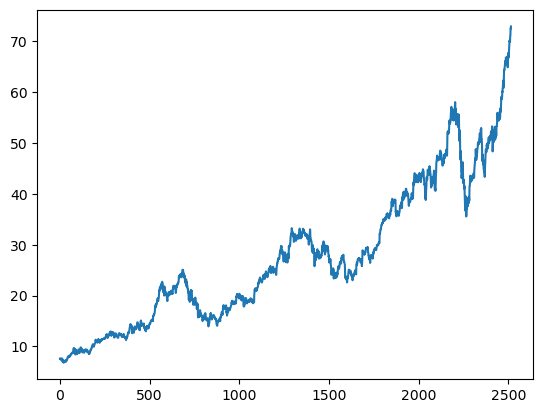

In [3]:
plt.plot(working_df.Close)

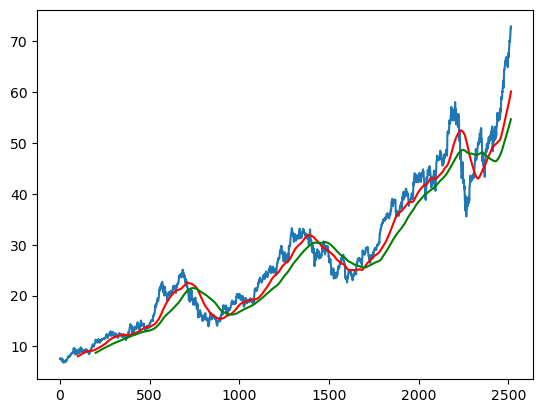

In [4]:
# Compute 100 Days Moving Average
moving_average_100 = working_df.Close.rolling(100).mean()

# Compute 200 Days Moving Average
moving_average_200 = working_df.Close.rolling(200).mean()

# Plot Closing Price & 100 Days Moving Average & 200 Days Moving Average
plt.figure()
plt.plot(working_df.Close)
plt.plot (moving_average_100, 'r')
plt.plot (moving_average_200, 'g')

In [5]:
# Splitting into Training & Testing Data
index_at_70 = int(len(working_df) * 0.7)
data_training = pd.DataFrame (working_df['Close'][0:index_at_70])
data_testing = pd.DataFrame (working_df['Close'][index_at_70:len(working_df)])

In [6]:
# Scale Down
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

/Users/chanyungkim/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
data_training_scaled_array = scaler.fit_transform (data_training)
data_training_scaled_array

array([[0.02971782],
       [0.03021854],
       [0.02560389],
       ...,
       [0.84388656],
       [0.85089656],
       [0.84616011]])

In [8]:
# Quick Logic : the price on a particular day depends on the previous 100 days
x_train = []
y_train = []

for i in range (100, data_training_scaled_array.shape[0]) :
    x_train.append(data_training_scaled_array [i-100 : i])
    y_train.append(data_training_scaled_array [i, 0])

x_train, y_train = np.array (x_train), np.array (y_train)

In [9]:
# ML Model
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

model = Sequential ()

model.add (LSTM (units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add (Dropout(0.2))

model.add (LSTM (units = 60, activation = 'relu', return_sequences = True))
model.add (Dropout(0.3))

model.add (LSTM (units = 80, activation = 'relu', return_sequences = True))
model.add (Dropout(0.4))

model.add (LSTM (units = 120, activation = 'relu'))
model.add (Dropout(0.4))

model.add (Dense (units = 1))

model.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [10]:
model.compile (optimizer = 'adam', loss = 'mean_squared_error')
model.fit (x_train, y_train, epochs = 50)

Epoch 1/50
52/52 [==============================] - 7s 110ms/step - loss: 0.0687
Epoch 2/50
52/52 [==============================] - 6s 112ms/step - loss: 0.0120
Epoch 3/50
52/52 [==============================] - 6s 113ms/step - loss: 0.0082
Epoch 4/50
52/52 [==============================] - 6s 120ms/step - loss: 0.0080
Epoch 5/50
52/52 [==============================] - 7s 136ms/step - loss: 0.0074
Epoch 6/50
52/52 [==============================] - 6s 112ms/step - loss: 0.0071
Epoch 7/50
52/52 [==============================] - 6s 112ms/step - loss: 0.0084
Epoch 8/50
52/52 [==============================] - 6s 113ms/step - loss: 0.0061
Epoch 9/50
52/52 [==============================] - 6s 120ms/step - loss: 0.0060
Epoch 10/50
52/52 [==============================] - 7s 125ms/step - loss: 0.0057
Epoch 11/50
52/52 [==============================] - 6s 112ms/step - loss: 0.0059
Epoch 12/50
52/52 [==============================] - 6s 116ms/step - loss: 0.0057
Epoch 13/50
52/52 [======

In [13]:
model.save('stock_predict_model.h5')

In [40]:
# modify the initial testing dataset
# full testing dataset => require to append previous 100 days to the initial testing data

past_100_days_from_initial_testing_dataset = data_training.tail (100)
#print (past_100_days_from_initial_testing_dataset)

modified_data_testing = pd.concat ([past_100_days_from_initial_testing_dataset, data_testing], ignore_index = True)
#print (modified_data_testing.head())

data_testing_scaled_array = scaler.fit_transform (modified_data_testing)
#data_testing_scaled_array.shape

In [41]:
# Quick Logic : the price on a particular day depends on the previous 100 days
x_test = []
y_test = []

for i in range (100, data_testing_scaled_array.shape[0]) :
    x_test.append(data_testing_scaled_array [i-100 : i])
    y_test.append(data_testing_scaled_array [i, 0])

x_test, y_test = np.array (x_test), np.array (y_test)

#print (x_test.shape, y_test.shape)

In [42]:
# using the trained ML to predict
y_predicted = model.predict(x_test)

24/24 [==============================] - 1s 28ms/step


In [43]:
# scale back 
scale_used = scaler.scale_
print (scale_used)
scale_up_factor = 1/scale_used[0]
y_predicted_scaled_back = y_predicted * scale_up_factor
y_test_scaled_back = y_test * scale_up_factor

[0.02123255]


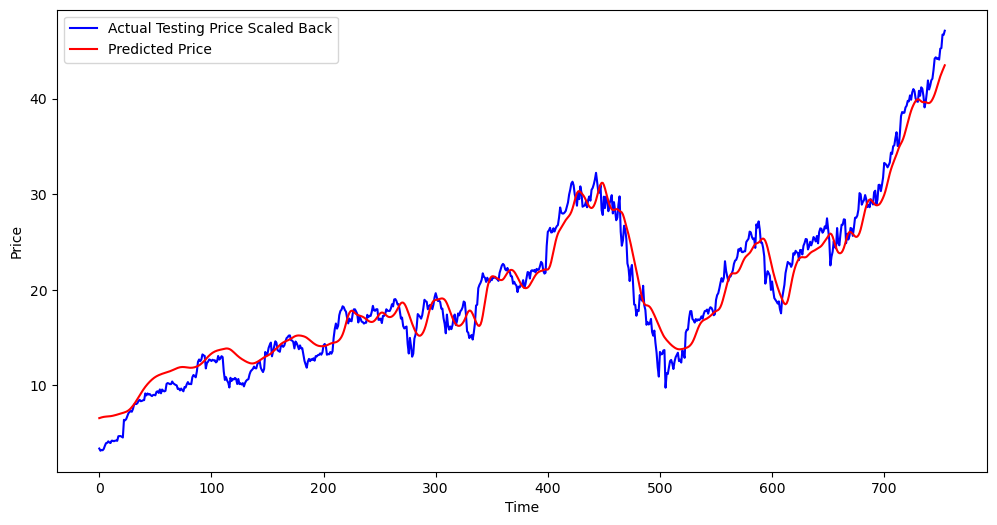

In [53]:
plt.figure(figsize = (12, 6))
plt.plot(y_test_scaled_back, 'b', label = "Actual Testing Price Scaled Back")
plt.plot(y_predicted_scaled_back, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

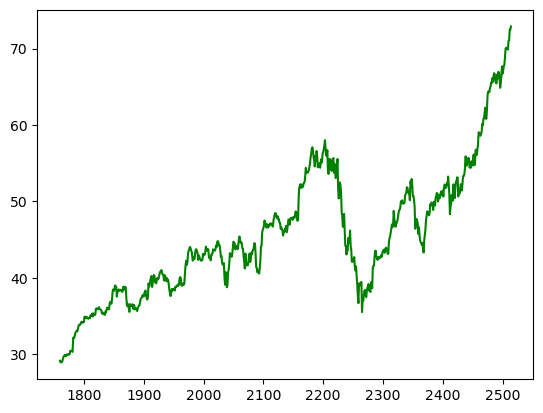

In [54]:
plt.plot(data_testing, 'g', label = "Actual Testing Price")